
### Submitted By: Capstone Group 1 - AIML MAY Group - 3
### Project: AIML Online Capstone - Pneumonia Detection Challenge - OD - ModelFromScratch - 8K

#### OBJECTIVE
To build a pneumonia detection system, to locate the position of inflammation in an image.
#### CONTEXT
Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.

While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.

In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.
#### DATA DESCRIPTION
Dicom original images: - Medical images are stored in a special format called DICOM files (\*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

### Step 1 - Perform imports

Let us imports all required packages before importing dataset

In [1]:
# Adding imports required for data cleansing and visualization
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline 

# Adding imports for misc and data prep
import os
import cv2
import pydicom #For displaying dcm images

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# %tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.6.3'

In [3]:
# Initialize the random number generator
import random

np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

from sklearn.model_selection import train_test_split

# NN Core imports
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.layers import Dropout, Dense, Flatten, BatchNormalization, MaxPool2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.utils import to_categorical, plot_model

Looking at the dir structure

In [4]:
# Lets have a look at the dir structure
!find ../input -maxdepth 1 -type d 

../input
../input/od-basic-ds-8k


Define input path parameters

In [5]:
input_path = "../input/od-basic-ds-8k/"

training_images_path = input_path + 'training_images.pkl'
training_masks_path = input_path + 'training_masks.pkl'
training_labels_path = input_path + 'training_labels.pkl'
coordinates_path = input_path + 'coordinates.pkl'

### Step 2 - Load data from saved data source

Let us load training images and mask arrays

In [6]:
originalImageSize = 1024
imageSize = 128

In [7]:
with open(training_images_path,'rb') as file:
    training_images = pickle.load(file)
    print("training_images -> Loading Complete")

with open(training_masks_path,'rb') as file:
    training_masks = pickle.load(file)
    print("training_masks -> Loading Complete")

with open(training_labels_path,'rb') as file:
    training_labels = pickle.load(file)
    print("training_labels -> Loading Complete")

with open(coordinates_path,'rb') as file:
    coordinates = pickle.load(file)
    print("coordinates -> Loading Complete")

training_images -> Loading Complete
training_masks -> Loading Complete
training_labels -> Loading Complete
coordinates -> Loading Complete


**- Check shape of pre-processed images -**

In [8]:
print ("Shape of training_images is -> ", training_images.shape)
print ("Shape of training_masks is -> ", training_masks.shape)
print ("Shape of training_labels is -> ", training_labels.shape)
print ("Shape of bounding box co-ordinates array is -> ", coordinates.shape)

Shape of training_images is ->  (8000, 128, 128, 3)
Shape of training_masks is ->  (8000, 128, 128)
Shape of training_labels is ->  (8000,)
Shape of bounding box co-ordinates array is ->  (8000, 4)


### Step 3 - Visualize the loaded data

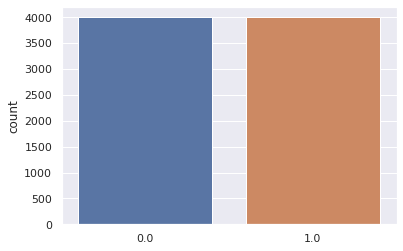

In [9]:
sns.countplot(training_labels);

**- Let's visualize test images and masks - For target 0 (Non-Pneunomia cases) -**

Out of 4000 samples, first 2000 samples are Non-Pneumonia cases

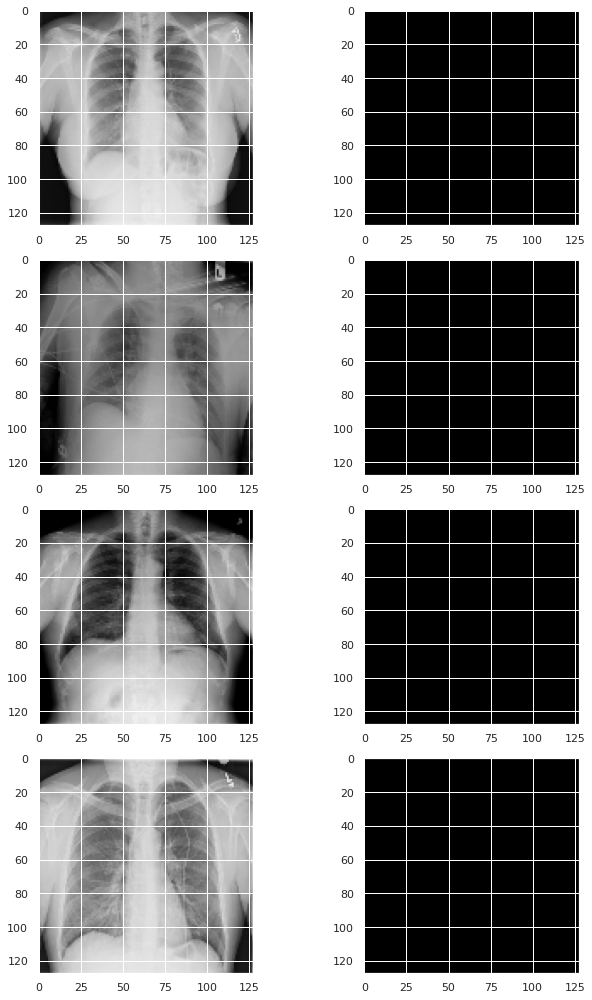

In [10]:
numOfRows = 4; # Number of samples to print
numOfCols = 2; # Two rows for display in each column. Index-0 for reference image and index-1 for related mask image

f, ax = plt.subplots(nrows=numOfRows, ncols=numOfCols, figsize=(10,14))
i=0;
for ro in range(0,4):
    ax[i, 0].imshow(training_images[ro].astype('uint8'), cmap=plt.cm.gist_gray);
    ax[i, 1].imshow(training_masks[ro], cmap=plt.cm.gist_gray);        
    i=i+1;
plt.tight_layout()
plt.show();

**- Let's visualize test images and masks - For target 1 (Pneunomia cases) -**

Out of 4000 samples, last 2000 samples are Pneumonia cases

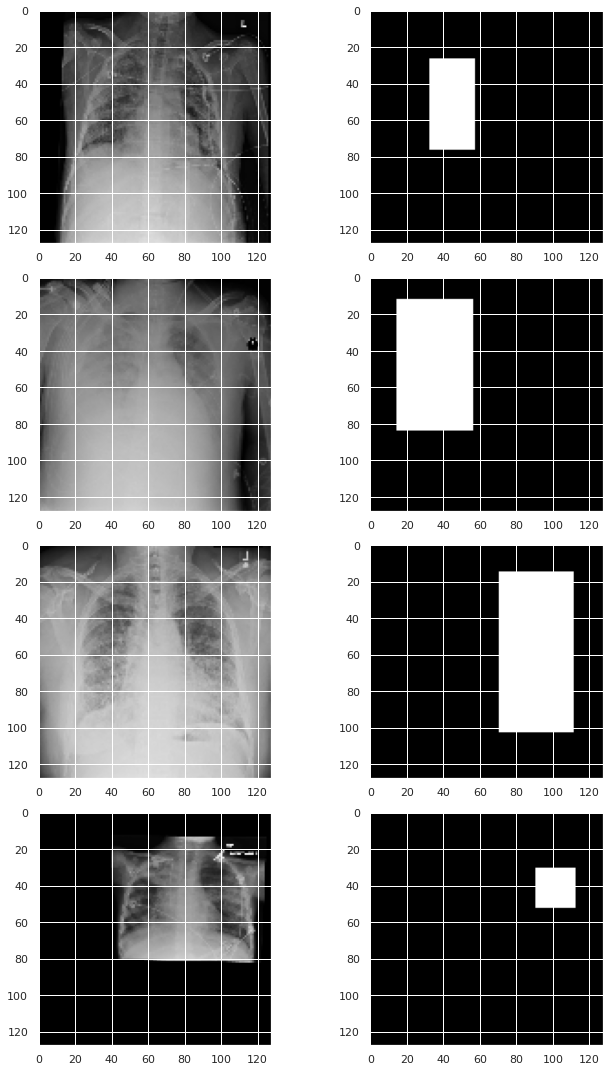

In [11]:
numOfRows = 4; # Number of samples to print
numOfCols = 2; # Two rows for display in each column. Index-0 for reference image and index-1 for related mask image

f, ax = plt.subplots(nrows=numOfRows, ncols=numOfCols, figsize=(10,15))
i=0;
for ro in range(4000, 4004):
    ax[i, 0].imshow(training_images[ro].astype('uint8'), cmap=plt.cm.gist_gray);
    ax[i, 1].imshow(training_masks[ro], cmap=plt.cm.gist_gray);        
    i=i+1;
plt.tight_layout()
plt.show();

### Step 4 - Data Prep for modeling

**- Let's split images/masks as train/test images -**

In [12]:
X_train, X_test, y_train, y_test, train_label, test_label, train_coor, test_coor = train_test_split(
    training_images, 
    training_masks, 
    training_labels,
    coordinates,
    test_size=0.2, random_state=1, stratify=training_labels)

X_val, X_test, y_val, y_test, val_label, test_label, val_coor, test_coor = train_test_split(
    X_test, 
    y_test, 
    test_label,
    test_coor,
    test_size=0.2, random_state=1, stratify=test_label)

print("Shape of X_train -> ", X_train.shape, ", Shape of y_train -> ", y_train.shape)
print("Shape of X_val -> ", X_val.shape, ", Shape of y_val -> ", y_val.shape)
print("Shape of X_test -> ", X_test.shape, ", Shape of y_test -> ", y_test.shape)
print("Shape of train_label -> ", train_label.shape, ", Shape of val_label -> ", val_label.shape, ", Shape of test_label is -> ", test_label.shape)
print("Shape of train_coor -> ", train_coor.shape, ", Shape of val_coor -> ", val_coor.shape, ", Shape of test_coor is -> ", test_coor.shape)

Shape of X_train ->  (6400, 128, 128, 3) , Shape of y_train ->  (6400, 128, 128)
Shape of X_val ->  (1280, 128, 128, 3) , Shape of y_val ->  (1280, 128, 128)
Shape of X_test ->  (320, 128, 128, 3) , Shape of y_test ->  (320, 128, 128)
Shape of train_label ->  (6400,) , Shape of val_label ->  (1280,) , Shape of test_label is ->  (320,)
Shape of train_coor ->  (6400, 4) , Shape of val_coor ->  (1280, 4) , Shape of test_coor is ->  (320, 4)


**- Distribution of Pneumonia and NonPneumonia cases after train_test_split -**

<AxesSubplot:ylabel='count'>

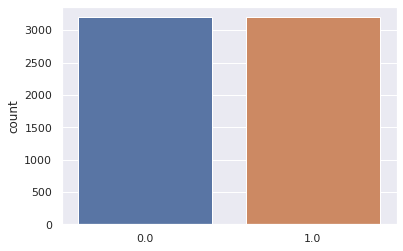

In [13]:
sns.countplot(train_label)

<AxesSubplot:ylabel='count'>

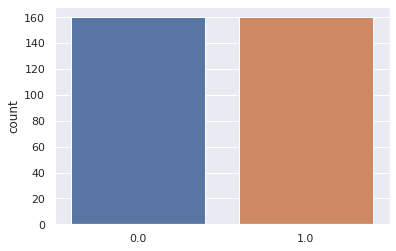

In [14]:
sns.countplot(test_label)

In [15]:
# First 10 labels
train_label[0:10]

array([0., 1., 0., 0., 0., 1., 0., 1., 1., 0.])

In [16]:
# Last 10 labels
train_label[-10:]

array([1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])

Labels are distributed and no more in the same order !

### Step 5 - Model design and fit

**- Let us write the basic model for image detection model -**

In [17]:
# To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)


def create_model():
    
    #Create a sequential model
    detection_base_model = Sequential()

    # 2D convolution layer
    detection_base_model.add(Input(shape=(imageSize, imageSize, 3)))
    detection_base_model.add(Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))
    detection_base_model.add(MaxPool2D(pool_size = (2,2))) # Max Pool layer 
    detection_base_model.add(BatchNormalization())

    detection_base_model.add(Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))
    detection_base_model.add(MaxPool2D(pool_size = (2,2)))
    detection_base_model.add(BatchNormalization())

    detection_base_model.add(Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
    detection_base_model.add(MaxPool2D(pool_size = (2,2)))
    detection_base_model.add(BatchNormalization())
    
    detection_base_model.add(Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))
    detection_base_model.add(MaxPool2D(pool_size = (2,2)))
    detection_base_model.add(BatchNormalization())

    detection_base_model.add(Conv2D(256, kernel_size=(3,3), strides = (1,1), activation='relu'))
    detection_base_model.add(MaxPool2D(pool_size = (2,2)))
    detection_base_model.add(BatchNormalization())

    flatten = Flatten()(detection_base_model.output)
    
    #Fully connected layer for Bounding Box detection (Regression)
    bb_reg = BatchNormalization()(flatten)
    bb_reg = Dense(256, activation='relu')(bb_reg)
    bb_reg = Dropout(0.5)(bb_reg)

    bb_reg = BatchNormalization()(bb_reg)
    bb_reg = Dense(128, activation='relu')(bb_reg)
    bb_reg = Dropout(0.5)(bb_reg)
    
    bb_reg = BatchNormalization()(bb_reg)
    bb_reg = Dense(64, activation='relu')(bb_reg)
    bb_reg = Dropout(0.5)(bb_reg)
    
    bb_reg = BatchNormalization()(bb_reg)
    bb_reg = Dense(32, activation='relu')(bb_reg)
    bb_reg = Dense(4, activation='linear', name='BB_Regression_Head')(bb_reg)

    #Fully connected layer for anamoly detection (Classification)
    target_classn = BatchNormalization()(flatten)
    target_classn = Dense(256, activation='relu')(target_classn)
    target_classn = Dropout(0.5)(target_classn)
    
    target_classn = BatchNormalization()(target_classn)
    target_classn = Dense(128, activation='relu')(target_classn)
    target_classn = Dropout(0.5)(target_classn)
    
    target_classn = BatchNormalization()(target_classn)
    target_classn = Dense(64, activation='relu')(target_classn)
    target_classn = Dropout(0.5)(target_classn)

    target_classn = BatchNormalization()(target_classn)
    target_classn = Dense(32, activation='relu')(target_classn)
    target_classn = Dense(1, activation='sigmoid', name='Target_Classification_Head')(target_classn)

    model = Model(inputs = detection_base_model.input, outputs = [bb_reg, target_classn])
    
    return model

In [18]:
# To get predictable results all the times
np.random.seed(1)
random.seed(1)
tensorflow.random.set_seed(1)

#Create the model
model = create_model()

#Define losses
losses = {
    "BB_Regression_Head": "mean_squared_error",
    "Target_Classification_Head": "binary_crossentropy"
}

#Define loss weights
loss_weights = {
    "BB_Regression_Head": 1.0,
    "Target_Classification_Head": 1.0
}

#Define metrics
metrics = {
    'BB_Regression_Head': 'mse',
    'Target_Classification_Head':  'accuracy'
}

# Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5)
    ,EarlyStopping(monitor='val_loss', patience=10)
    ,ModelCheckpoint('OD_Basic_ModelFromScratch_8k.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
]

# Initialize Optimizer
optimizer = Adagrad(lr = 0.01)

# Compile the model
model.compile(optimizer = optimizer, loss = losses, loss_weights = loss_weights, metrics = metrics)
model.summary()

2022-05-05 17:45:29.288015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:45:29.409594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:45:29.410467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:45:29.412569: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 63, 63, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

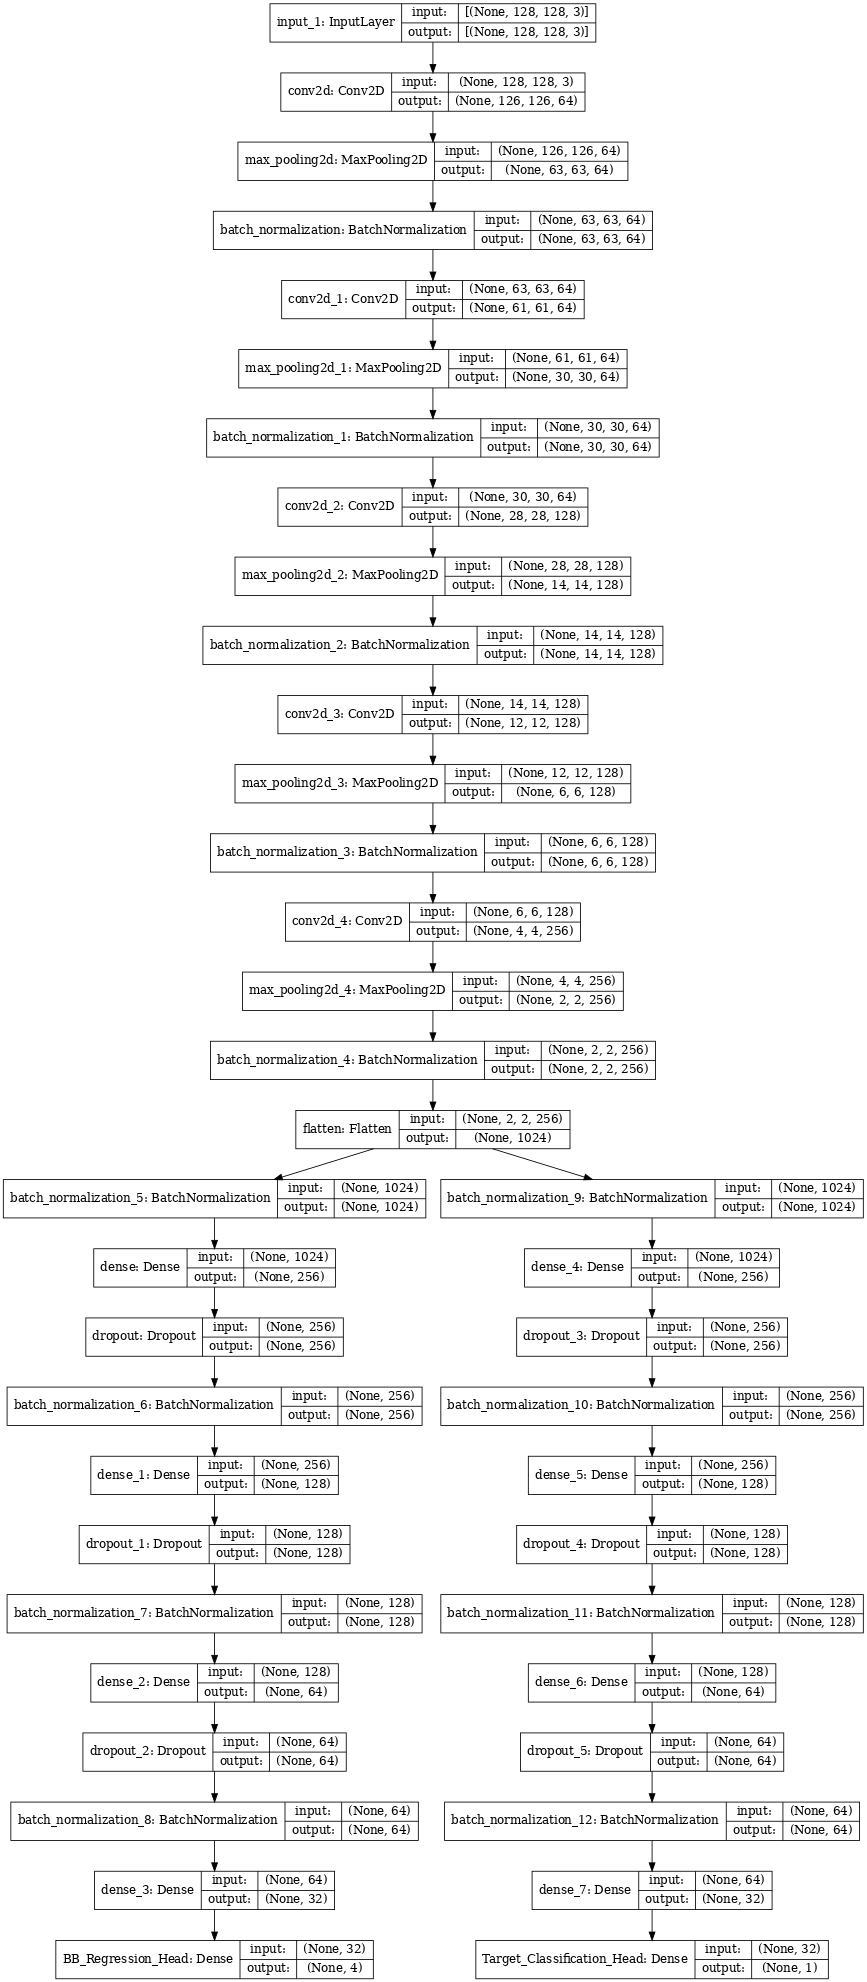

In [19]:
plot_model(model, 
           to_file='PneumoniaDetectionModel.png', 
           show_shapes=True, 
           show_layer_names=True, 
           rankdir='TB',
           dpi=60,
           layer_range=None)

In [20]:
# Train the Model
history = model.fit(x = X_train, 
                    y = {"BB_Regression_Head": train_coor, "Target_Classification_Head": train_label}, 
                    validation_data=(
                        X_val, 
                        {"BB_Regression_Head": val_coor, "Target_Classification_Head": val_label}
                    ), 
                    batch_size = 32, 
                    callbacks = callbacks,
                    epochs = 50)

2022-05-05 17:45:34.702538: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1258291200 exceeds 10% of free system memory.
2022-05-05 17:45:36.073144: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1258291200 exceeds 10% of free system memory.
2022-05-05 17:45:37.033819: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-05 17:45:39.930161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


198/200 [============================>.] - ETA: 0s - loss: 605.6318 - BB_Regression_Head_loss: 604.9774 - Target_Classification_Head_loss: 0.6544 - BB_Regression_Head_mse: 604.9774 - Target_Classification_Head_accuracy: 0.6277

2022-05-05 17:45:49.789173: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 251658240 exceeds 10% of free system memory.
2022-05-05 17:45:50.107944: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 251658240 exceeds 10% of free system memory.


200/200 [==============================] - 14s 27ms/step - loss: 604.1195 - BB_Regression_Head_loss: 603.4657 - Target_Classification_Head_loss: 0.6538 - BB_Regression_Head_mse: 603.4657 - Target_Classification_Head_accuracy: 0.6280 - val_loss: 799.6578 - val_BB_Regression_Head_loss: 798.7773 - val_Target_Classification_Head_loss: 0.8807 - val_BB_Regression_Head_mse: 798.7773 - val_Target_Classification_Head_accuracy: 0.5805

Epoch 00001: val_loss improved from inf to 799.65784, saving model to OD_Basic_ModelFromScratch_8k.h5
Epoch 2/50
200/200 [==============================] - 4s 20ms/step - loss: 478.6653 - BB_Regression_Head_loss: 478.0992 - Target_Classification_Head_loss: 0.5660 - BB_Regression_Head_mse: 478.0992 - Target_Classification_Head_accuracy: 0.7147 - val_loss: 487.5583 - val_BB_Regression_Head_loss: 487.0193 - val_Target_Classification_Head_loss: 0.5392 - val_BB_Regression_Head_mse: 487.0193 - val_Target_Classification_Head_accuracy: 0.7375

Epoch 00002: val_loss improv

**- Model Statistics on Training and Validation data -**

Classification metrics

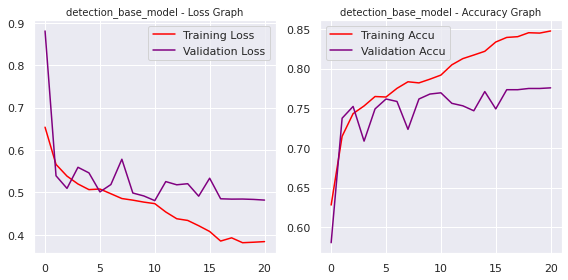

In [21]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

plt.title('Image Classification Plots')

ax[0].set_title("detection_base_model - Loss Graph", fontsize=10)
ax[0].plot(history.history["Target_Classification_Head_loss"], color='red')
ax[0].plot(history.history["val_Target_Classification_Head_loss"], color='purple')
ax[0].legend(["Training Loss", "Validation Loss"], loc='best')

ax[1].set_title("detection_base_model - Accuracy Graph", fontsize=10)
ax[1].plot(history.history["Target_Classification_Head_accuracy"], color='red')
ax[1].plot(history.history["val_Target_Classification_Head_accuracy"], color='purple')
ax[1].legend(["Training Accu", "Validation Accu"], loc='best')

plt.tight_layout()
plt.show()

Regression Metrics

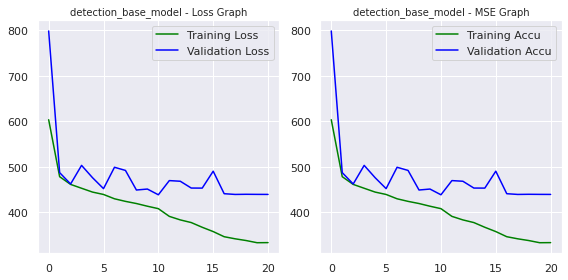

In [22]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

plt.title('Bounding box Regression Plots')

ax[0].set_title("detection_base_model - Loss Graph", fontsize=10)
ax[0].plot(history.history["BB_Regression_Head_loss"], color='green')
ax[0].plot(history.history["val_BB_Regression_Head_loss"], color='blue')
ax[0].legend(["Training Loss", "Validation Loss"], loc='best')

ax[1].set_title("detection_base_model - MSE Graph", fontsize=10)
ax[1].plot(history.history["BB_Regression_Head_mse"], color='green')
ax[1].plot(history.history["val_BB_Regression_Head_mse"], color='blue')
ax[1].legend(["Training Accu", "Validation Accu"], loc='best')

plt.tight_layout()
plt.show()

**Evaluate the model using testing data**

In [23]:
model.evaluate(x = X_test, y = {"BB_Regression_Head" : test_coor, "Target_Classification_Head" : test_label})

10/10 [==============================] - 0s 8ms/step - loss: 448.6941 - BB_Regression_Head_loss: 448.2225 - Target_Classification_Head_loss: 0.4716 - BB_Regression_Head_mse: 448.2225 - Target_Classification_Head_accuracy: 0.7937


2022-05-05 17:48:01.893896: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 62914560 exceeds 10% of free system memory.


[448.694091796875,
 448.22247314453125,
 0.4716237485408783,
 448.22247314453125,
 0.793749988079071]

### Step 6 -  Prediction with models

#### Step 6.1 Perform prediction with fit model and perform save()

In [24]:
def predict_preprocess(img):

    # Prediction for image
    image_array = np.array([img])
    predict_image_arr = model.predict(image_array)

    #Extract x1, y1 co-ordinates and width, height of bounding box
    x1, y1, width, height = int(predict_image_arr[0][0][0]), int(predict_image_arr[0][0][1]), int(predict_image_arr[0][0][2]), int(predict_image_arr[0][0][3])
    
    print ("Predicted co-ordinates -> ", x1, y1, width, height)
    print ("Predicted target class -> ", np.round(predict_image_arr[1][0][0]).astype('uint32'))

    #Apply bounding box co-ordinates and draw lines for the bounding box
    y2 = y1 + height
    x2 = x1 + width
    img[y1:y1 + 1, x1:x2] = 1
    img[y2:y2 + 1, x1:x2] = 1
    img[y1:y2, x1:x1 + 1] = 1
    img[y1:y2, x2:x2 + 1] = 1
    return (img)

Predicted co-ordinates ->  2 3 1 0
Predicted target class ->  0


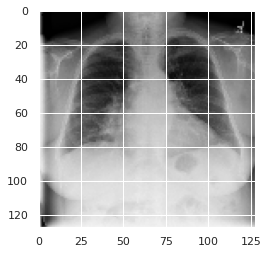

In [25]:
# Prediction for image-0 in test data
plt.imshow(predict_preprocess(X_test[0].astype('uint32')), cmap=plt.cm.gist_gray);

Predicted co-ordinates ->  36 35 20 31
Predicted target class ->  1


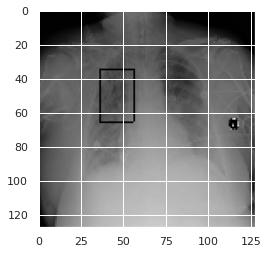

In [26]:
# Prediction for image-5 in test data
plt.imshow(predict_preprocess(X_test[5].astype('uint32')), cmap=plt.cm.gist_gray);

**- Save the built model -**

In [27]:
model.save('OD_Basic_ModelFromScratch_8k_final.h5')

#### Step 6.2 Perform prediction with saved model (with checkpoint)

**Perform prediction from saved model**

In [28]:
def predict_preprocess_savedModel(modell, img):

    # Prediction for image
    image_array = np.array([img])
    predict_image_arr = modell.predict(image_array)

    #Extract x1, y1 co-ordinates and width, height of bounding box
    x1, y1, width, height = int(predict_image_arr[0][0][0]), int(predict_image_arr[0][0][1]), int(predict_image_arr[0][0][2]), int(predict_image_arr[0][0][3])
    
    print ("Predicted co-ordinates -> ", x1, y1, width, height)
    print ("Predicted target class -> ", np.round(predict_image_arr[1][0][0]).astype('uint32'))

    #Apply bounding box co-ordinates and draw lines for the bounding box
    y2 = y1 + height
    x2 = x1 + width
    img[y1:y1 + 1, x1:x2] = 1
    img[y2:y2 + 1, x1:x2] = 1
    img[y1:y2, x1:x1 + 1] = 1
    img[y1:y2, x2:x2 + 1] = 1
    return (img)

Predicted co-ordinates ->  32 32 18 27
Predicted target class ->  1


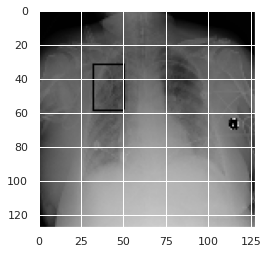

In [29]:
savedModel = keras.models.load_model('./OD_Basic_ModelFromScratch_8k.h5')

# Prediction for image-5 in test data
plt.imshow(predict_preprocess_savedModel(savedModel, X_test[5].astype('uint32')), cmap=plt.cm.gist_gray);

Predicted co-ordinates ->  3 5 2 0
Predicted target class ->  0


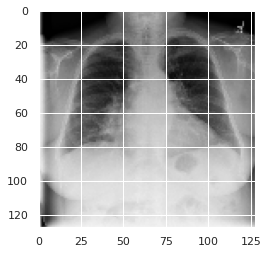

In [30]:
# Prediction for image-0 in test data
plt.imshow(predict_preprocess_savedModel(savedModel, X_test[0].astype('uint32')), cmap=plt.cm.gist_gray);

#### Step 6.3 Perform prediction with final saved model (h5 format)

Predicted co-ordinates ->  36 35 20 31
Predicted target class ->  1


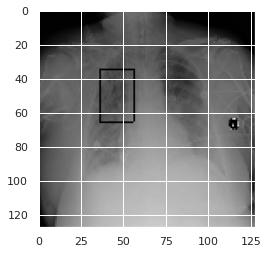

In [31]:
savedModel_h5 = keras.models.load_model('./OD_Basic_ModelFromScratch_8k_final.h5')

# Prediction for image-5 in test data
plt.imshow(predict_preprocess_savedModel(savedModel_h5, X_test[5].astype('uint32')), cmap=plt.cm.gist_gray);

Predicted co-ordinates ->  2 3 1 0
Predicted target class ->  0


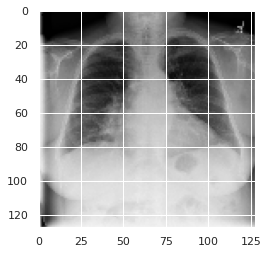

In [32]:
# Prediction for image-0 in test data
plt.imshow(predict_preprocess_savedModel(savedModel_h5, X_test[0].astype('uint32')), cmap=plt.cm.gist_gray);